In [1]:
# Packages 

import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator as pchip
import scipy.optimize as opt

In [2]:
# Set Parameters 

beta = 0.8 
R = 1.02
phi = 0.8

In [32]:
# Define Functions

@njit
def u(c):
    u = np.log(c)
    return u 

@njit
def u_dash(c):
    ## Marginal Utility
    ud = 1/c
    return ud 

@njit
def f(k):
    y = k ** (1/3)
    return y 

@njit
def f_dash(k):
    ## Marginal Product
    return (1/3) * k ** (-2/3)

@njit
def k_opt(R):
    ## Optimal capital is a function of R
    ## Derived in the question
    return (3 * R) ** (-3/2) 

## First-Order Conditions

def foc_constrained(k_prime, w, v_dash, phi, R, beta):
    """ 
    Fn to solve for unknown kprime
    Note: w is a scalar 
    Returns 0 at optimal value of k_prime 
    """
    MUc = u_dash(w - (1 - phi) * k_prime) * (1 - phi)  ## marginal utility from consuming today, note the 1 - phi term from capital constraint
    MUs = beta * v_dash(f(k_prime) - R * phi * k_prime)  * f_dash(k_prime - R * phi)  ## marginal utility from saving in capital today. 
    output = MUc - MUs 
    return output 

def foc_unconstrained(b_prime, w, v_dash, phi , R, beta):
    """ 
    Fn to solve for unknown bprime
    Note: w_uncons is a scalar 
    Returns 0 at optimal value of b_prime 
    """
    kstar = k_opt(R)
    MUc = u_dash(w - (1 - phi) * kstar) ## marginal utility from consuming today
    MUs = beta * R * v_dash(f(kstar) + R * b_prime) ## marginal utility from saving today.
    output = MUc - MUs
    return output 

## Cutoff condition for constrained vs unconstrained 

def threshold(w_thr, v_dash, phi, R, beta):
    """
    Function to solve for unknown threshold w_thr
    """
    kstar = k_opt(R)
    MUc = u_dash(w_thr - (1 - phi) * kstar)
    MUs = beta * R * v_dash(f(kstar) - R * phi * kstar) ## marginal utility from saving today.
    output = MUc - MUs
    return output 


In [103]:
# Set up discrete grid for w
w_grid = np.linspace(5, 10, 1000)

In [104]:
# Define a function that solves for the optimal kprime and bprime given w. 

def solve_kprime_bprime(wgrid, phi, R, beta):

    # Form an initial guess for the value function 

    vprime_old = wgrid

    # Set up empty arrays to store the optimal kprime and bprime

    kprime = np.zeros(len(wgrid))
    bprime = np.zeros(len(wgrid))

    # Run the value function iteration algorithm. 

    ## First, we specify the tolerance level for the algorithm.

    tol = 1e-6

    ## Next, we set up a while loop that will run until the distance between the old and new value functions is less than the tolerance level.

    dist = 1

    while dist > tol:

        # Set up an empty array to store the new value function

        vprime_new = np.empty(len(wgrid))

        # Form a cubic spline approximation to the new value function

        vprime_old_poly = pchip(wgrid, vprime_old)

        # Define a function vprime_old_deriv that takes in a scalar and returns the derivative of the cubic spline approximation at that point

        vprime_old_deriv = vprime_old_poly.derivative(1)

        # Use the threshold function to find the threshold w_star 

        w_star = opt.fsolve(threshold, 0.5, args = (vprime_old_deriv, phi, R, beta))
        print(w_star)

        # Solve for the optimal Vprime, kprime, bprime for w < w_star

        for i in range(len(wgrid)):

            if wgrid[i] < w_star:

                # Solve for the optimal kprime

                kprime[i] = opt.fsolve(foc_constrained, 1, args=(wgrid[i], vprime_old_deriv, phi, R, beta))

                # Solve for the optimal bprime

                bprime[i] = 0

            else:

                # Solve for the optimal bprime

                bprime[i] = opt.fsolve(foc_unconstrained, 1, args=(wgrid[i], vprime_old_deriv, phi, R, beta))

                # Solve for the optimal kprime

                kprime[i] = k_opt(R)

            # Calculate the new value function

            ## Calculate w_prime 

            w_prime = f(kprime[i]) + R * bprime[i]

            ## Find closest value of w_prime in the grid

            w_prime_index = np.argmin(np.abs(wgrid - w_prime))

            ## Calculate the new value function

            vprime_new[i] = u(wgrid[i] - bprime[i] - kprime[i]) + beta * vprime_old[w_prime_index]
        
        print(vprime_new)

        # Calculate the distance between the old and new value functions

        dist = np.max(np.abs(vprime_new - vprime_old))

        # Update the old value function with the new value function. 

        vprime_old = vprime_new

    return kprime, bprime, vprime_new

In [105]:
capital_policy, bond_policy, value_function = solve_kprime_bprime(w_grid, phi, R, beta)

[1.26285372]
[5.33846411 5.3397758  5.34108577 5.34239404 5.34370059 5.34500543
 5.34630858 5.34761003 5.34890979 5.35020786 5.35150425 5.35279896
 5.35409199 5.35538336 5.35667306 5.3579611  5.35924748 5.36053221
 5.36181529 5.36309673 5.36437653 5.36565469 5.36693122 5.36820612
 5.3694794  5.37075106 5.37202111 5.37328954 5.37455637 5.37582159
 5.37708522 5.37834725 5.37960769 5.38086654 5.38212381 5.3833795
 5.38463362 5.38588617 5.38713715 5.38838656 5.38963442 5.39088072
 5.39212547 5.39336868 5.39461033 5.39585045 5.39708904 5.39832609
 5.39956161 5.40079561 5.40202809 5.40325905 5.4044885  5.40571643
 5.40694287 5.40816779 5.40939123 5.41061316 5.41183361 5.41305256
 5.41427003 5.41548603 5.41670054 5.41791358 5.41912516 5.42033526
 5.42154391 5.42275109 5.42395682 5.4251611  5.42636393 5.42756531
 5.42876525 5.42996375 5.43116082 5.43235646 5.43355067 5.43474346
 5.43593482 5.43712477 5.4383133  5.43950042 5.44068614 5.44187045
 5.44305335 5.44423486 5.44541498 5.44659371 5.447

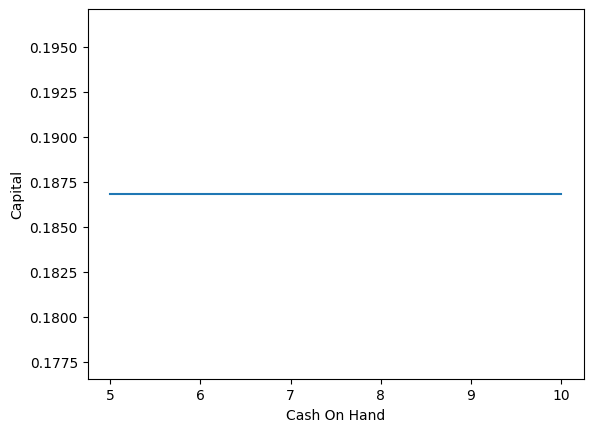

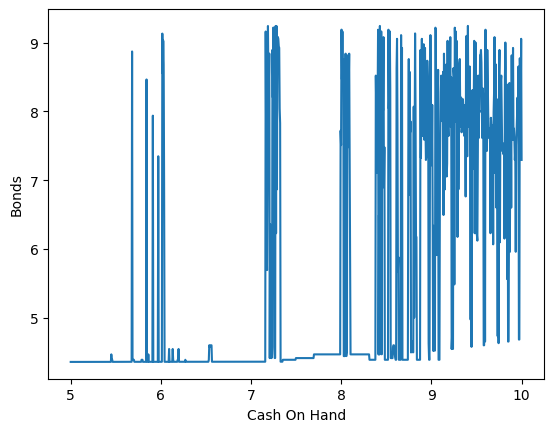

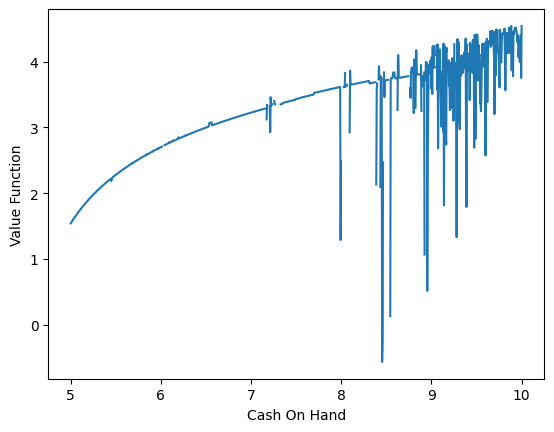

In [106]:
# Plot the policy function capital_policy

plt.plot(w_grid, capital_policy)
plt.xlabel('Cash On Hand')
plt.ylabel('Capital')

## Show the chart

plt.show()

# Plot the policy function bond_policy

plt.plot(w_grid, bond_policy)
plt.xlabel('Cash On Hand')
plt.ylabel('Bonds')

## Show the chart

plt.show()

# Plot the value function

plt.plot(w_grid, value_function)
plt.xlabel('Cash On Hand')
plt.ylabel('Value Function')

## Show the chart

plt.show()





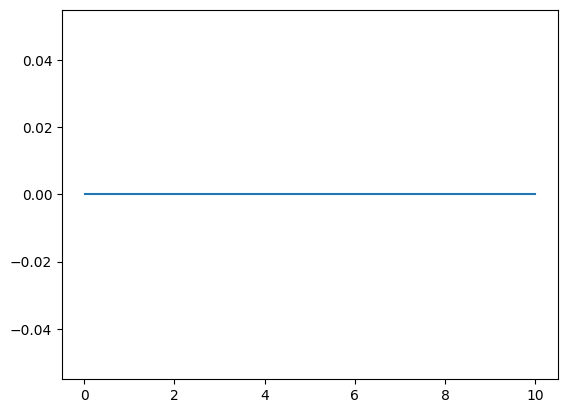

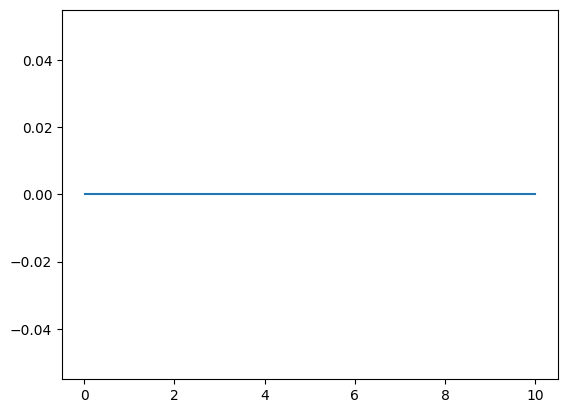

In [100]:
vprime_old_poly = pchip(w_grid, np.zeros(len(w_grid)))
## plot vprime_old_poly
plt.plot(w_grid, vprime_old_poly(w_grid))
plt.show()

# Calculate derivative of vprime_old_poly

vprime_old_deriv = vprime_old_poly.derivative(1)

# Plot the derivative of vprime_old_poly

plt.plot(w_grid, vprime_old_deriv(w_grid))
plt.show()
